<a href="https://colab.research.google.com/github/Ganesh-DSML/DSML-Practice/blob/main/PYT_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1. Download images from the internet

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO

In [ ]:
def download_images(image_urls, save_dir, prefix = 'IMG_'):
  os.makedirs(save_dir, exist_ok=True)
  for i, url in enumerate(image_urls):
    try:
      resp = requests.get(url, timeout=10)
      resp.raise_for_status()
      img = Image.open(BytesIO(resp.content)).convert("RGB")
      fname = os.path.join(save_dir, f'{prefix}_{i}.jpg')
      img.save(fname)
    except Exception as e:
      print(f'Error downloading image {url} : {e}')

In [3]:
car_urls = [
    'https://stimg.cardekho.com/images/carexteriorimages/630x420/Jaguar/F-Pace/10644/1755774688332/front-left-side-47.jpg?impolicy=resize&imwidth=480',
    'https://img.autocarindia.com/ExtraImages/20241205062334_20240606032223_Creta%20showroom%20shot%20_1_.jpg',
    'https://cdni.autocarindia.com/Features/_New%20Sedans%20%20Sports%20Cars%20Web%20Resized%20%20Watermarked._008.jpeg',
    'https://a.storyblok.com/f/197805/7a2484c876/how-to-create-a-car-newblogcover.png',
    'https://kidsroar.in/cdn/shop/files/8989898_ff5f50c0-0de9-45c8-b9fb-61c8aa0ef070_800x.jpg?v=1692355576'
            ]

truck_urls = [
    'https://www.tatamotors.com/wp-content/uploads/2023/10/press-13sep23-01.jpg',
    'https://plus.unsplash.com/premium_photo-1664695368767-c42483a0bda1?fm=jpg&q=60&w=3000&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8dHJ1Y2t8ZW58MHx8MHx8fDA%3D',
    'https://www.macktrucks.com/trucks/media_1818f3d88d2375704ad949bbd5f4d34ec2039895f.png?width=750&format=png&optimize=medium',
    'https://5.imimg.com/data5/MW/JN/FM/SELLER-89031277/10-chakka-for-sale-in-indore-1000x1000.png',
    'https://fordtrucksglobal.com/Uploads/Page/technologies_05.jpg'
 ]
ute_urls = [
    'https://www.chevrolet.com/content/dam/chevrolet/na/us/english/vdc-collections/2025/trucks/colorado/nav/2025-colorado-4zr-gal-driver-front-3quarter-nav.jpg?imwidth=960',
    'https://imgd.aeplcdn.com/1280x720/n/cw/ec/191395/kia-left-front-three-quarter1.jpeg?isig=0',
    'https://autoimage.capitalone.com/cms/Auto/assets/images/3403-hero-2024-chevrolet-silverado-hd-zr2.jpg',
    'https://www.topgear.com/sites/default/files/news-listicle/image/2023/11/TRUCKSLEAD.jpg',
    'https://static01.nytimes.com/newsgraphics/2023-02-14-big-evs/a09067a7b772d4328be9141db7df9f91b33c0e04/_assets/cars-rivian-rivian.jpg'
]

download_images(car_urls, 'data/cars', prefix = 'CAR')
download_images(truck_urls, 'data/trucks', prefix = 'TRUCK')
download_images(ute_urls, 'data/utes', prefix = 'UTE')

### Step 2. Imports & transforms (image preprocessing / augmentation)

In [4]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

### Step 3. Build ImageFolder + stratified train/val split

In [6]:
data_directory = 'data'
data_for_split = datasets.ImageFolder(root =data_directory)
indices = list(range(len(data_for_split)))
labels = [s[1] for s in data_for_split.samples]
train_indices, val_indices = train_test_split(indices, test_size=0.2, stratify = labels, random_state=42)
train_dataset_full = datasets.ImageFolder(root = data_directory, transform = train_transform)
val_dataset_full = datasets.ImageFolder(root = data_directory, transform = val_transform)
train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

In [7]:
print(f'Total Images: {len(data_for_split)}')
print(f'Train Images: {len(train_dataset)}')
print(f'Validation Images: {len(val_dataset)}')
print(f'Class Names: {data_for_split.classes}')

Total Images: 15
Train Images: 12
Validation Images: 3
Class Names: ['cars', 'trucks', 'utes']


### Step 4. DataLoaders (batches, shuffling, prefetch)

In [8]:
batch_size = 32
num_workers =  2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False, num_workers=num_workers, pin_memory=True)

### Step 5. Build the model (transfer learning with ResNet18)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained = True)

for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features
num_classes = len(data_for_split.classes)
model.fc = nn.Linear(num_ftrs, num_classes)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 93.9MB/s]


### Step 6. Loss, optimizer, and (optional) learning rate scheduler

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Step 7. Training & validation loop

In [11]:
import time
from tqdm import tqdm

def train_1_epoch(model, dataloader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  running_corrects = 0.0

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() *inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_acc = running_corrects.double() / len(dataloader.dataset)
  return epoch_loss, epoch_acc.item()

In [12]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0.0
  running_corrects = 0.0

  all_preds = []
  all_labels = []

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(preds==labels.data)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_acc = running_corrects.double() / len(dataloader.dataset)
  return epoch_loss, epoch_acc.item(), np.array(all_labels), np.array(all_preds)

In [13]:
#Train Loop
num_epochs = 5
best_val_acc = 0.0
best_model_wts = None

for epoch in range(num_epochs):
  since = time.time()
  train_loss, train_acc = train_1_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc, val_labels, val_preds = evaluate(model, val_loader, criterion, device)

  scheduler.step()

  if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_model_wts = model.state_dict()

  print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} - "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f} - "
          f"time: {time.time()-since:.1f}s")

if best_model_wts is not None:
  model.load_state_dict(best_model_wts)
  torch.save(best_model_wts, 'best_model.pth')
  print('Save best_model.pth with val acc:', best_val_acc)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 - Train loss: 1.3421, Train acc: 0.3333 - Val loss: 1.0652, Val acc: 0.3333 - time: 3.0s
Epoch 2/5 - Train loss: 1.1371, Train acc: 0.4167 - Val loss: 1.0295, Val acc: 0.6667 - time: 1.8s
Epoch 3/5 - Train loss: 1.0916, Train acc: 0.4167 - Val loss: 1.0176, Val acc: 0.6667 - time: 1.8s
Epoch 4/5 - Train loss: 0.9914, Train acc: 0.5833 - Val loss: 1.0048, Val acc: 0.6667 - time: 2.7s
Epoch 5/5 - Train loss: 0.9522, Train acc: 0.5833 - Val loss: 0.9703, Val acc: 0.6667 - time: 2.2s
Save best_model.pth with val acc: 0.6666666666666666


### Step 8. Confusion matrix, normalized matrix, and per-class accuracy (visualize)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
cm = confusion_matrix(val_labels, val_preds)
print('Confusion Matrix:', cm)

Confusion Matrix: [[1 0 0]
 [0 1 0]
 [0 1 0]]


In [17]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix:', cm_normalized)

Normalized Confusion Matrix: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


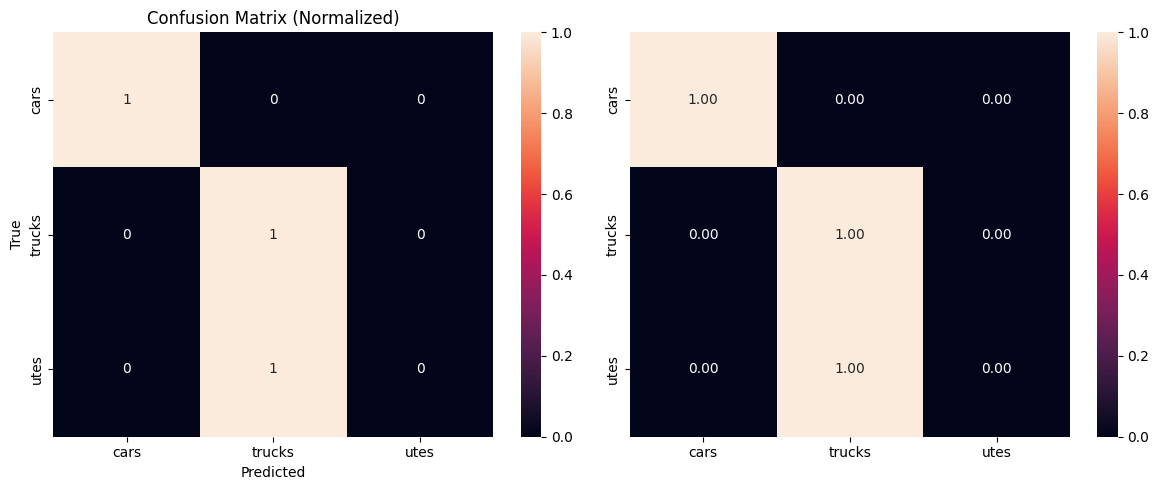

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm, annot=True, fmt = 'd', xticklabels=data_for_split.classes, yticklabels=data_for_split.classes, ax = ax[0])
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel("True")

sns.heatmap(cm_normalized, annot=True, fmt = '.2f', xticklabels=data_for_split.classes, yticklabels=data_for_split.classes, ax = ax[1])
ax[0].set_title('Confusion Matrix (Normalized)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel("True")

plt.tight_layout()
plt.show()

cars: 100.00%
trucks: 100.00%
utes: 0.00%


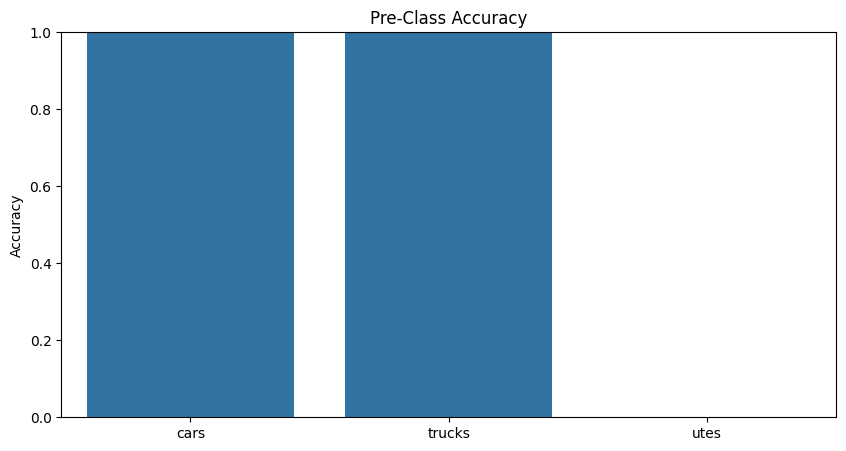

              precision    recall  f1-score   support

        cars       1.00      1.00      1.00         1
      trucks       0.50      1.00      0.67         1
        utes       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
class_acc = np.diag(cm)/cm.sum(axis =1)
for cls, acc in zip(data_for_split.classes, class_acc):
  print(f'{cls}:{acc: .2%}')

plt.figure(figsize=(10,5))
sns.barplot(x=data_for_split.classes, y=class_acc)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Pre-Class Accuracy')
plt.show()

print(classification_report(val_labels, val_preds, target_names=data_for_split.classes))